In [ ]:
import pandas as pd
import pyarrow as pa
import os
import zipfile
import matplotlib.pyplot as plt 
from collections import Counter
import numpy as np
import statsmodels.api as sm
import pylab
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

pd.options.display.float_format = '{:.2f}'.format

AHHHHH1

# Information 
EIA's State Energy Data System (SEDS) is a comprehensive data set that consists of annual time series estimates of state-level energy use by major economic sectors, energy production and and State-level energy price and expenditure data. The system provides data back from 1960. Data are presented in physical units, BTUs, and dollars. While some SEDS data series come directly from surveys conducted by EIA, many are estimated using other available information. These estimations are necessary for the compilation of "total energy" estimates.

Useful Links:
https://catalog.data.gov/dataset/state-energy-data-system-seds

https://www.eia.gov/state/seds/

Codes and descriptions
https://www.eia.gov/state/seds/CDF/Codes_and_Descriptions.xlsx


From the State Data energy System description sheets: \
The MSNs are five-character codes, most of which are structured as follows:
First and second characters - describes an energy source (for example, NG for natural gas, MG for motor gasoline)
Third and fourth characters - describes an energy sector or an energy activity (for example, RC for residential consumption, PR for production)
Fifth character - describes a type of data (for example, P for data in physical unit, B for data in billion Btu and D is for dollars per million BTU)

Going to use 
WYTCB -Wind energy total consumption -Billion BTU
SOTCB- Solar Energy total consumption-Billion BTU
+state ~ price (ESRCV) Electricity expenditures in the residential sector

CLRCB  -Coal consumed by the residential sector
GERCB  -Geothermal energy consumed by the residential sector - not good too few
PARCB  -All petroleum products consumed by the residential sector
PERCD- Primary energy average price in the residential sector


The aim of this project is to predict the Primary average price in the private sector.




In [ ]:
os.getcwd() # Geting the current working directory

'c:\\Users\\amcfa\\gitfiles\\Projects\\MastersWork\\shorter_ML_Projects'

In [7]:
file = pd.read_csv(os.getcwd()+ '\Complete_SEDS.csv')
file1=file

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
C:\Users\amcfa\AppData\Local\Temp\ipykernel_23008\956361923.py:1: SyntaxWarning: invalid escape sequence '\C'
  file = pd.read_csv(os.getcwd()+ '\Complete_SEDS.csv')


After loading in and reading the data the first thing to do is to look over it

In [8]:
print("there are over",len(file1),'entries in this file')

there are over 2007511 entries in this file


In [9]:
file1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007511 entries, 0 to 2007510
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Data_Status  object 
 1   MSN          object 
 2   StateCode    object 
 3   Year         int64  
 4   Data         float64
dtypes: float64(1), int64(1), object(3)
memory usage: 76.6+ MB


In [10]:
print("There are:",len(file1['MSN'].unique()),"unique categories")

There are: 764 unique categories


In [11]:
file1['Year'] = pd.to_datetime(file1['Year'], format='%Y')
print(file1.head())

  Data_Status    MSN StateCode       Year  Data
0       2021F  ABICB        AK 1960-01-01  0.00
1       2021F  ABICB        AK 1961-01-01  0.00
2       2021F  ABICB        AK 1962-01-01  0.00
3       2021F  ABICB        AK 1963-01-01  0.00
4       2021F  ABICB        AK 1964-01-01  0.00


In [12]:
file1=file1[~(file1['StateCode']=='US')]


## Looking at a few categories

What about instead prices?

In [13]:
wind_energy= file1[file1['MSN'].str.contains('WYTCB')]
petroleum_energy= file1[file1['MSN'].str.contains('PARCB')]
geothermal_energy= file1[file1['MSN'].str.contains('GERCB')]
solar_energy= file1[file1['MSN'].str.contains('SOTCB')]
general_consumption= file1[file1['MSN'].str.contains('ESRCV')]
primary_energy_average_price= file1[file1['MSN'].str.contains('PERCD')]

Electricity price per residential sector

In [14]:
print(len(wind_energy),len(solar_energy),len(petroleum_energy),len(geothermal_energy),len(general_consumption))

3162 3162 3162 3162 2652


It can be assumed that 0 values are values where data was not tracked. So I will try to exclude those.

In [15]:
wind_energy[wind_energy['Data']>=0]
solar_energy[solar_energy['Data']>=0]
petroleum_energy[petroleum_energy['Data']>=0]
geothermal_energy[geothermal_energy['Data']>=0]



,Data_Status,MSN,StateCode,Year,Data
643195,2021F,GERCB,AK,1960-01-01,0.00
643196,2021F,GERCB,AK,1961-01-01,0.00
643197,2021F,GERCB,AK,1962-01-01,0.00
643198,2021F,GERCB,AK,1963-01-01,0.00
643199,2021F,GERCB,AK,1964-01-01,0.00
...,...,...,...,...,...
646414,2021F,GERCB,WY,2017-01-01,70.00
646415,2021F,GERCB,WY,2018-01-01,70.00
646416,2021F,GERCB,WY,2019-01-01,70.00
646417,2021F,GERCB,WY,2020-01-01,70.00


It does end up removing many of the data points. But there are still a few thousand to work with. 

In [16]:
wind_energy_shorter=wind_energy[~(wind_energy["Data"]<=0)]
solar_energy_shorter=solar_energy[~(solar_energy["Data"]<=0)]
petroleum_energy_shorter=petroleum_energy[~(petroleum_energy['Data']<=0)]
geothermal_energy_shorter=geothermal_energy[~(geothermal_energy['Data']<=0)]
general_consumption_shorter=general_consumption[~(general_consumption["Data"]<=0)]
primary_energy_average_price_shorter=primary_energy_average_price[~(primary_energy_average_price["Data"]<=0)]

In [17]:
print(wind_energy_shorter.info(),
solar_energy_shorter.info(),
general_consumption_shorter.info())


<class 'pandas.core.frame.DataFrame'>
Index: 798 entries, 1988208 to 1991390
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data_Status  798 non-null    object        
 1   MSN          798 non-null    object        
 2   StateCode    798 non-null    object        
 3   Year         798 non-null    datetime64[ns]
 4   Data         798 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 37.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 1659 entries, 1708000 to 1711194
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Data_Status  1659 non-null   object        
 1   MSN          1659 non-null   object        
 2   StateCode    1659 non-null   object        
 3   Year         1659 non-null   datetime64[ns]
 4   Data         1659 non-null   float64       
dtypes: datetime64[ns](

In [18]:
wind_energy_shorter.describe()

,Year,Data
count,798,798.00
mean,2010-04-11 13:46:27.969924864,34191.23
min,1983-01-01 00:00:00,1.00
25%,2006-01-01 00:00:00,857.25
50%,2012-01-01 00:00:00,7320.00
75%,2017-01-01 00:00:00,34719.00
max,2021-01-01 00:00:00,879750.00
std,NaN,79155.76


In [19]:
solar_energy_shorter.describe()

,Year,Data
count,1659,1659.00
mean,2005-01-30 03:17:54.141048832,5243.56
min,1984-01-01 00:00:00,1.00
25%,1997-01-01 00:00:00,38.00
50%,2005-01-01 00:00:00,199.00
75%,2013-01-01 00:00:00,1216.00
max,2021-01-01 00:00:00,502419.00
std,NaN,26854.56


In [20]:
general_consumption_shorter.describe()

,Year,Data
count,2652,2652.00
mean,1995-07-02 18:00:00,1892.11
min,1970-01-01 00:00:00,15.50
25%,1982-10-01 18:00:00,327.55
50%,1995-07-02 12:00:00,958.75
75%,2008-04-01 12:00:00,2361.10
max,2021-01-01 00:00:00,20604.40
std,NaN,2620.08


In [21]:
geothermal_energy_shorter.describe()

,Year,Data
count,1549,1549.00
mean,2005-09-04 06:40:40.284054144,462.37
min,1989-01-01 00:00:00,1.00
25%,1998-01-01 00:00:00,50.00
50%,2006-01-01 00:00:00,141.00
75%,2014-01-01 00:00:00,439.00
max,2021-01-01 00:00:00,7976.00
std,NaN,970.93


In [22]:
petroleum_energy_shorter.describe()

,Year,Data
count,3162,3162.00
mean,1990-07-02 12:00:00,33569.95
min,1960-01-01 00:00:00,49.00
25%,1975-01-01 00:00:00,6732.25
50%,1990-07-02 12:00:00,15583.00
75%,2006-01-01 00:00:00,36667.75
max,2021-01-01 00:00:00,404117.00
std,NaN,50492.88


In [23]:
primary_energy_average_price_shorter.describe()

,Year,Data
count,2652,2652.00
mean,1995-07-02 18:00:00,8.45
min,1970-01-01 00:00:00,0.82
25%,1982-10-01 18:00:00,5.00
50%,1995-07-02 12:00:00,7.12
75%,2008-04-01 12:00:00,11.57
max,2021-01-01 00:00:00,50.07
std,NaN,5.66


In [24]:
wind_energy_shorter.head(1)

,Data_Status,MSN,StateCode,Year,Data
1988208,2021F,WYTCB,AK,2001-01-01,10.00


In [25]:
import plotly.express as px

fig = px.scatter(wind_energy_shorter, x="StateCode", y="Data", title = "?", color = 'Year',width=1200, height=900)
fig.show()

ModuleNotFoundError: No module named 'plotly'

In [26]:
np.histogram(wind_energy_shorter['Data'],bins=10, range=[0,max(wind_energy_shorter['Data'])])


(array([716,  54,  14,   6,   2,   0,   1,   2,   1,   2], dtype=int64),
 array([     0.,  87975., 175950., 263925., 351900., 439875., 527850.,
        615825., 703800., 791775., 879750.]))

Text(0, 0.5, 'Count')

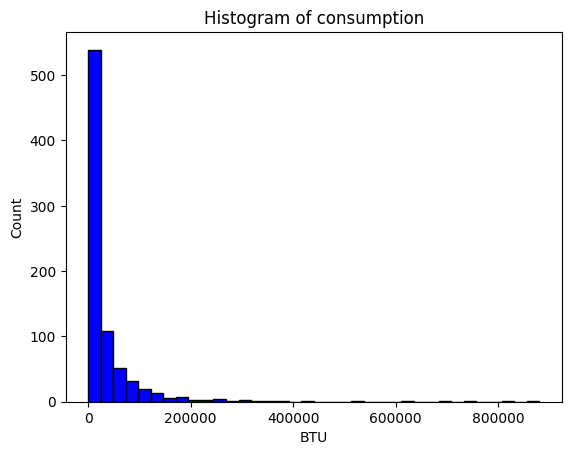

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(wind_energy_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Histogram of consumption')
plt.xlabel('BTU')
plt.ylabel('Count')

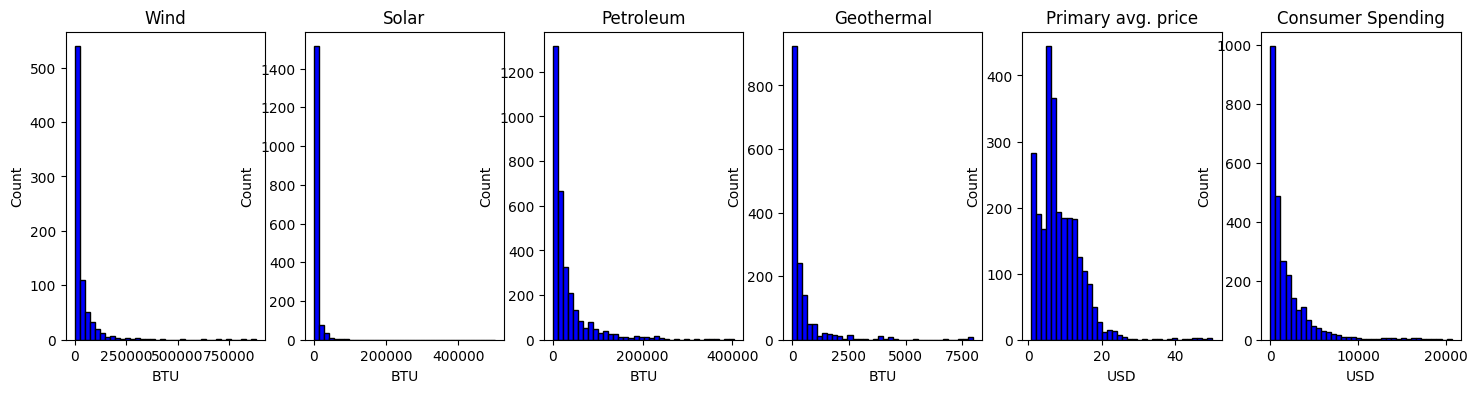

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 4)) 
plt.subplot(1,6,1)

plt.hist(wind_energy_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Wind')
plt.xlabel('BTU')
plt.ylabel('Count')
plt.subplot(1,6,2)
plt.hist(solar_energy_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Solar')
plt.xlabel('BTU')
plt.ylabel('Count')

plt.subplot(1,6,3)
plt.hist(petroleum_energy_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Petroleum')
plt.xlabel('BTU')
plt.ylabel('Count')
plt.subplot(1,6,4)
plt.hist(geothermal_energy_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Geothermal')
plt.xlabel('BTU')
plt.ylabel('Count')
plt.subplot(1,6,5)
plt.hist(primary_energy_average_price_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Primary avg. price')
plt.xlabel('USD')
plt.ylabel('Count')
plt.subplot(1,6,6)
plt.hist(general_consumption_shorter['Data'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))
plt.title('Consumer Spending')
plt.xlabel('USD')
plt.ylabel('Count')

plt.show()


In [29]:
## Rename columns

wind_energy_shorter=wind_energy_shorter.rename(columns={'Data':'Wind_Energy_Consumption_BTU','MSN':'Wind_Energy_Total_abbr'})

petroleum_energy_shorter=petroleum_energy_shorter.rename(columns={'Data':'Petroleum_Energy_Consumption_BTU','MSN':'Petroleum_Energy_Total_abbr'})

geothermal_energy_shorter=geothermal_energy_shorter.rename(columns={'Data':'Geothermal_Energy_Consumption_BTU','MSN':'Geothermal_Energy_Total_abbr'})
primary_energy_average_price_shorter=primary_energy_average_price_shorter.rename(columns={'Data':'Primary_Energy_Avg_price_USD',
                                                                                          'MSN':'Primary_Energy_Avg_price_abbr'})

In [30]:
solar_energy_shorter=solar_energy_shorter.rename(columns={'Data':'Solar_Energy_Consumption_BTU','MSN':'Solar_Energy_Total_abbr'})

In [31]:
general_consumption_shorter=general_consumption_shorter.rename(columns={'Data':'Cost_in_Millions_of_Dollars_To_consumers',
                                                                        'MSN':'Consumer_Energy_Cost_Abbr'})

In [32]:
merged_data= wind_energy_shorter.merge(solar_energy_shorter, on=["StateCode","Year",'Data_Status'])

In [33]:
merged_data

,Data_Status,Wind_Energy_Total_abbr,StateCode,Year,Wind_Energy_Consumption_BTU,Solar_Energy_Total_abbr,Solar_Energy_Consumption_BTU
0,2021F,WYTCB,AK,2008-01-01,1.00,SOTCB,2.00
1,2021F,WYTCB,AK,2009-01-01,69.00,SOTCB,3.00
2,2021F,WYTCB,AK,2010-01-01,123.00,SOTCB,3.00
3,2021F,WYTCB,AK,2011-01-01,121.00,SOTCB,3.00
4,2021F,WYTCB,AK,2012-01-01,356.00,SOTCB,3.00
...,...,...,...,...,...,...,...
774,2021F,WYTCB,WY,2017-01-01,39785.00,SOTCB,45.00
775,2021F,WYTCB,WY,2018-01-01,36912.00,SOTCB,67.00
776,2021F,WYTCB,WY,2019-01-01,37045.00,SOTCB,1687.00
777,2021F,WYTCB,WY,2020-01-01,48329.00,SOTCB,1565.00


In [34]:
merged_data2= petroleum_energy_shorter.merge(merged_data, on=["StateCode","Year",'Data_Status'])

In [35]:
merged_data2

,Data_Status,Petroleum_Energy_Total_abbr,StateCode,Year,Petroleum_Energy_Consumption_BTU,Wind_Energy_Total_abbr,Wind_Energy_Consumption_BTU,Solar_Energy_Total_abbr,Solar_Energy_Consumption_BTU
0,2021F,PARCB,AK,2008-01-01,8749.00,WYTCB,1.00,SOTCB,2.00
1,2021F,PARCB,AK,2009-01-01,9446.00,WYTCB,69.00,SOTCB,3.00
2,2021F,PARCB,AK,2010-01-01,9359.00,WYTCB,123.00,SOTCB,3.00
3,2021F,PARCB,AK,2011-01-01,8682.00,WYTCB,121.00,SOTCB,3.00
4,2021F,PARCB,AK,2012-01-01,8362.00,WYTCB,356.00,SOTCB,3.00
...,...,...,...,...,...,...,...,...,...
774,2021F,PARCB,WY,2017-01-01,3623.00,WYTCB,39785.00,SOTCB,45.00
775,2021F,PARCB,WY,2018-01-01,3390.00,WYTCB,36912.00,SOTCB,67.00
776,2021F,PARCB,WY,2019-01-01,3620.00,WYTCB,37045.00,SOTCB,1687.00
777,2021F,PARCB,WY,2020-01-01,3066.00,WYTCB,48329.00,SOTCB,1565.00


In [36]:
merged_data3= merged_data2.merge(geothermal_energy_shorter, on=["StateCode","Year",'Data_Status'])

In [37]:
merged_data3

,Data_Status,Petroleum_Energy_Total_abbr,StateCode,Year,Petroleum_Energy_Consumption_BTU,Wind_Energy_Total_abbr,Wind_Energy_Consumption_BTU,Solar_Energy_Total_abbr,Solar_Energy_Consumption_BTU,Geothermal_Energy_Total_abbr,Geothermal_Energy_Consumption_BTU
0,2021F,PARCB,AK,2008-01-01,8749.00,WYTCB,1.00,SOTCB,2.00,GERCB,59.00
1,2021F,PARCB,AK,2009-01-01,9446.00,WYTCB,69.00,SOTCB,3.00,GERCB,77.00
2,2021F,PARCB,AK,2010-01-01,9359.00,WYTCB,123.00,SOTCB,3.00,GERCB,79.00
3,2021F,PARCB,AK,2011-01-01,8682.00,WYTCB,121.00,SOTCB,3.00,GERCB,126.00
4,2021F,PARCB,AK,2012-01-01,8362.00,WYTCB,356.00,SOTCB,3.00,GERCB,101.00
...,...,...,...,...,...,...,...,...,...,...,...
735,2021F,PARCB,WY,2017-01-01,3623.00,WYTCB,39785.00,SOTCB,45.00,GERCB,70.00
736,2021F,PARCB,WY,2018-01-01,3390.00,WYTCB,36912.00,SOTCB,67.00,GERCB,70.00
737,2021F,PARCB,WY,2019-01-01,3620.00,WYTCB,37045.00,SOTCB,1687.00,GERCB,70.00
738,2021F,PARCB,WY,2020-01-01,3066.00,WYTCB,48329.00,SOTCB,1565.00,GERCB,70.00


In [38]:
merged_data4= primary_energy_average_price_shorter.merge(merged_data3, on=["StateCode","Year",'Data_Status'])

In [39]:
merged_data5=general_consumption_shorter.merge(merged_data4,on=["StateCode","Year",'Data_Status'])

In [40]:
merged_data5

,Data_Status,Consumer_Energy_Cost_Abbr,StateCode,Year,Cost_in_Millions_of_Dollars_To_consumers,Primary_Energy_Avg_price_abbr,Primary_Energy_Avg_price_USD,Petroleum_Energy_Total_abbr,Petroleum_Energy_Consumption_BTU,Wind_Energy_Total_abbr,Wind_Energy_Consumption_BTU,Solar_Energy_Total_abbr,Solar_Energy_Consumption_BTU,Geothermal_Energy_Total_abbr,Geothermal_Energy_Consumption_BTU
0,2021F,ESRCV,AK,2008-01-01,352.60,PERCD,13.78,PARCB,8749.00,WYTCB,1.00,SOTCB,2.00,GERCB,59.00
1,2021F,ESRCV,AK,2009-01-01,362.90,PERCD,13.00,PARCB,9446.00,WYTCB,69.00,SOTCB,3.00,GERCB,77.00
2,2021F,ESRCV,AK,2010-01-01,340.30,PERCD,13.30,PARCB,9359.00,WYTCB,123.00,SOTCB,3.00,GERCB,79.00
3,2021F,ESRCV,AK,2011-01-01,376.00,PERCD,14.19,PARCB,8682.00,WYTCB,121.00,SOTCB,3.00,GERCB,126.00
4,2021F,ESRCV,AK,2012-01-01,386.30,PERCD,13.96,PARCB,8362.00,WYTCB,356.00,SOTCB,3.00,GERCB,101.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,2021F,ESRCV,WY,2017-01-01,315.30,PERCD,11.57,PARCB,3623.00,WYTCB,39785.00,SOTCB,45.00,GERCB,70.00
736,2021F,ESRCV,WY,2018-01-01,310.20,PERCD,11.32,PARCB,3390.00,WYTCB,36912.00,SOTCB,67.00,GERCB,70.00
737,2021F,ESRCV,WY,2019-01-01,318.40,PERCD,10.24,PARCB,3620.00,WYTCB,37045.00,SOTCB,1687.00,GERCB,70.00
738,2021F,ESRCV,WY,2020-01-01,319.90,PERCD,9.97,PARCB,3066.00,WYTCB,48329.00,SOTCB,1565.00,GERCB,70.00


In [41]:
merged_data1=merged_data5

In [42]:
merged_data4[merged_data4['StateCode']=='US']

,Data_Status,Primary_Energy_Avg_price_abbr,StateCode,Year,Primary_Energy_Avg_price_USD,Petroleum_Energy_Total_abbr,Petroleum_Energy_Consumption_BTU,Wind_Energy_Total_abbr,Wind_Energy_Consumption_BTU,Solar_Energy_Total_abbr,Solar_Energy_Consumption_BTU,Geothermal_Energy_Total_abbr,Geothermal_Energy_Consumption_BTU


In [43]:
import plotly.express as px

fig = px.box(merged_data1, x="Year", y="Cost_in_Millions_of_Dollars_To_consumers", title = "?", color = 'Year',width=1200, height=900)
fig.show()

ModuleNotFoundError: No module named 'plotly'

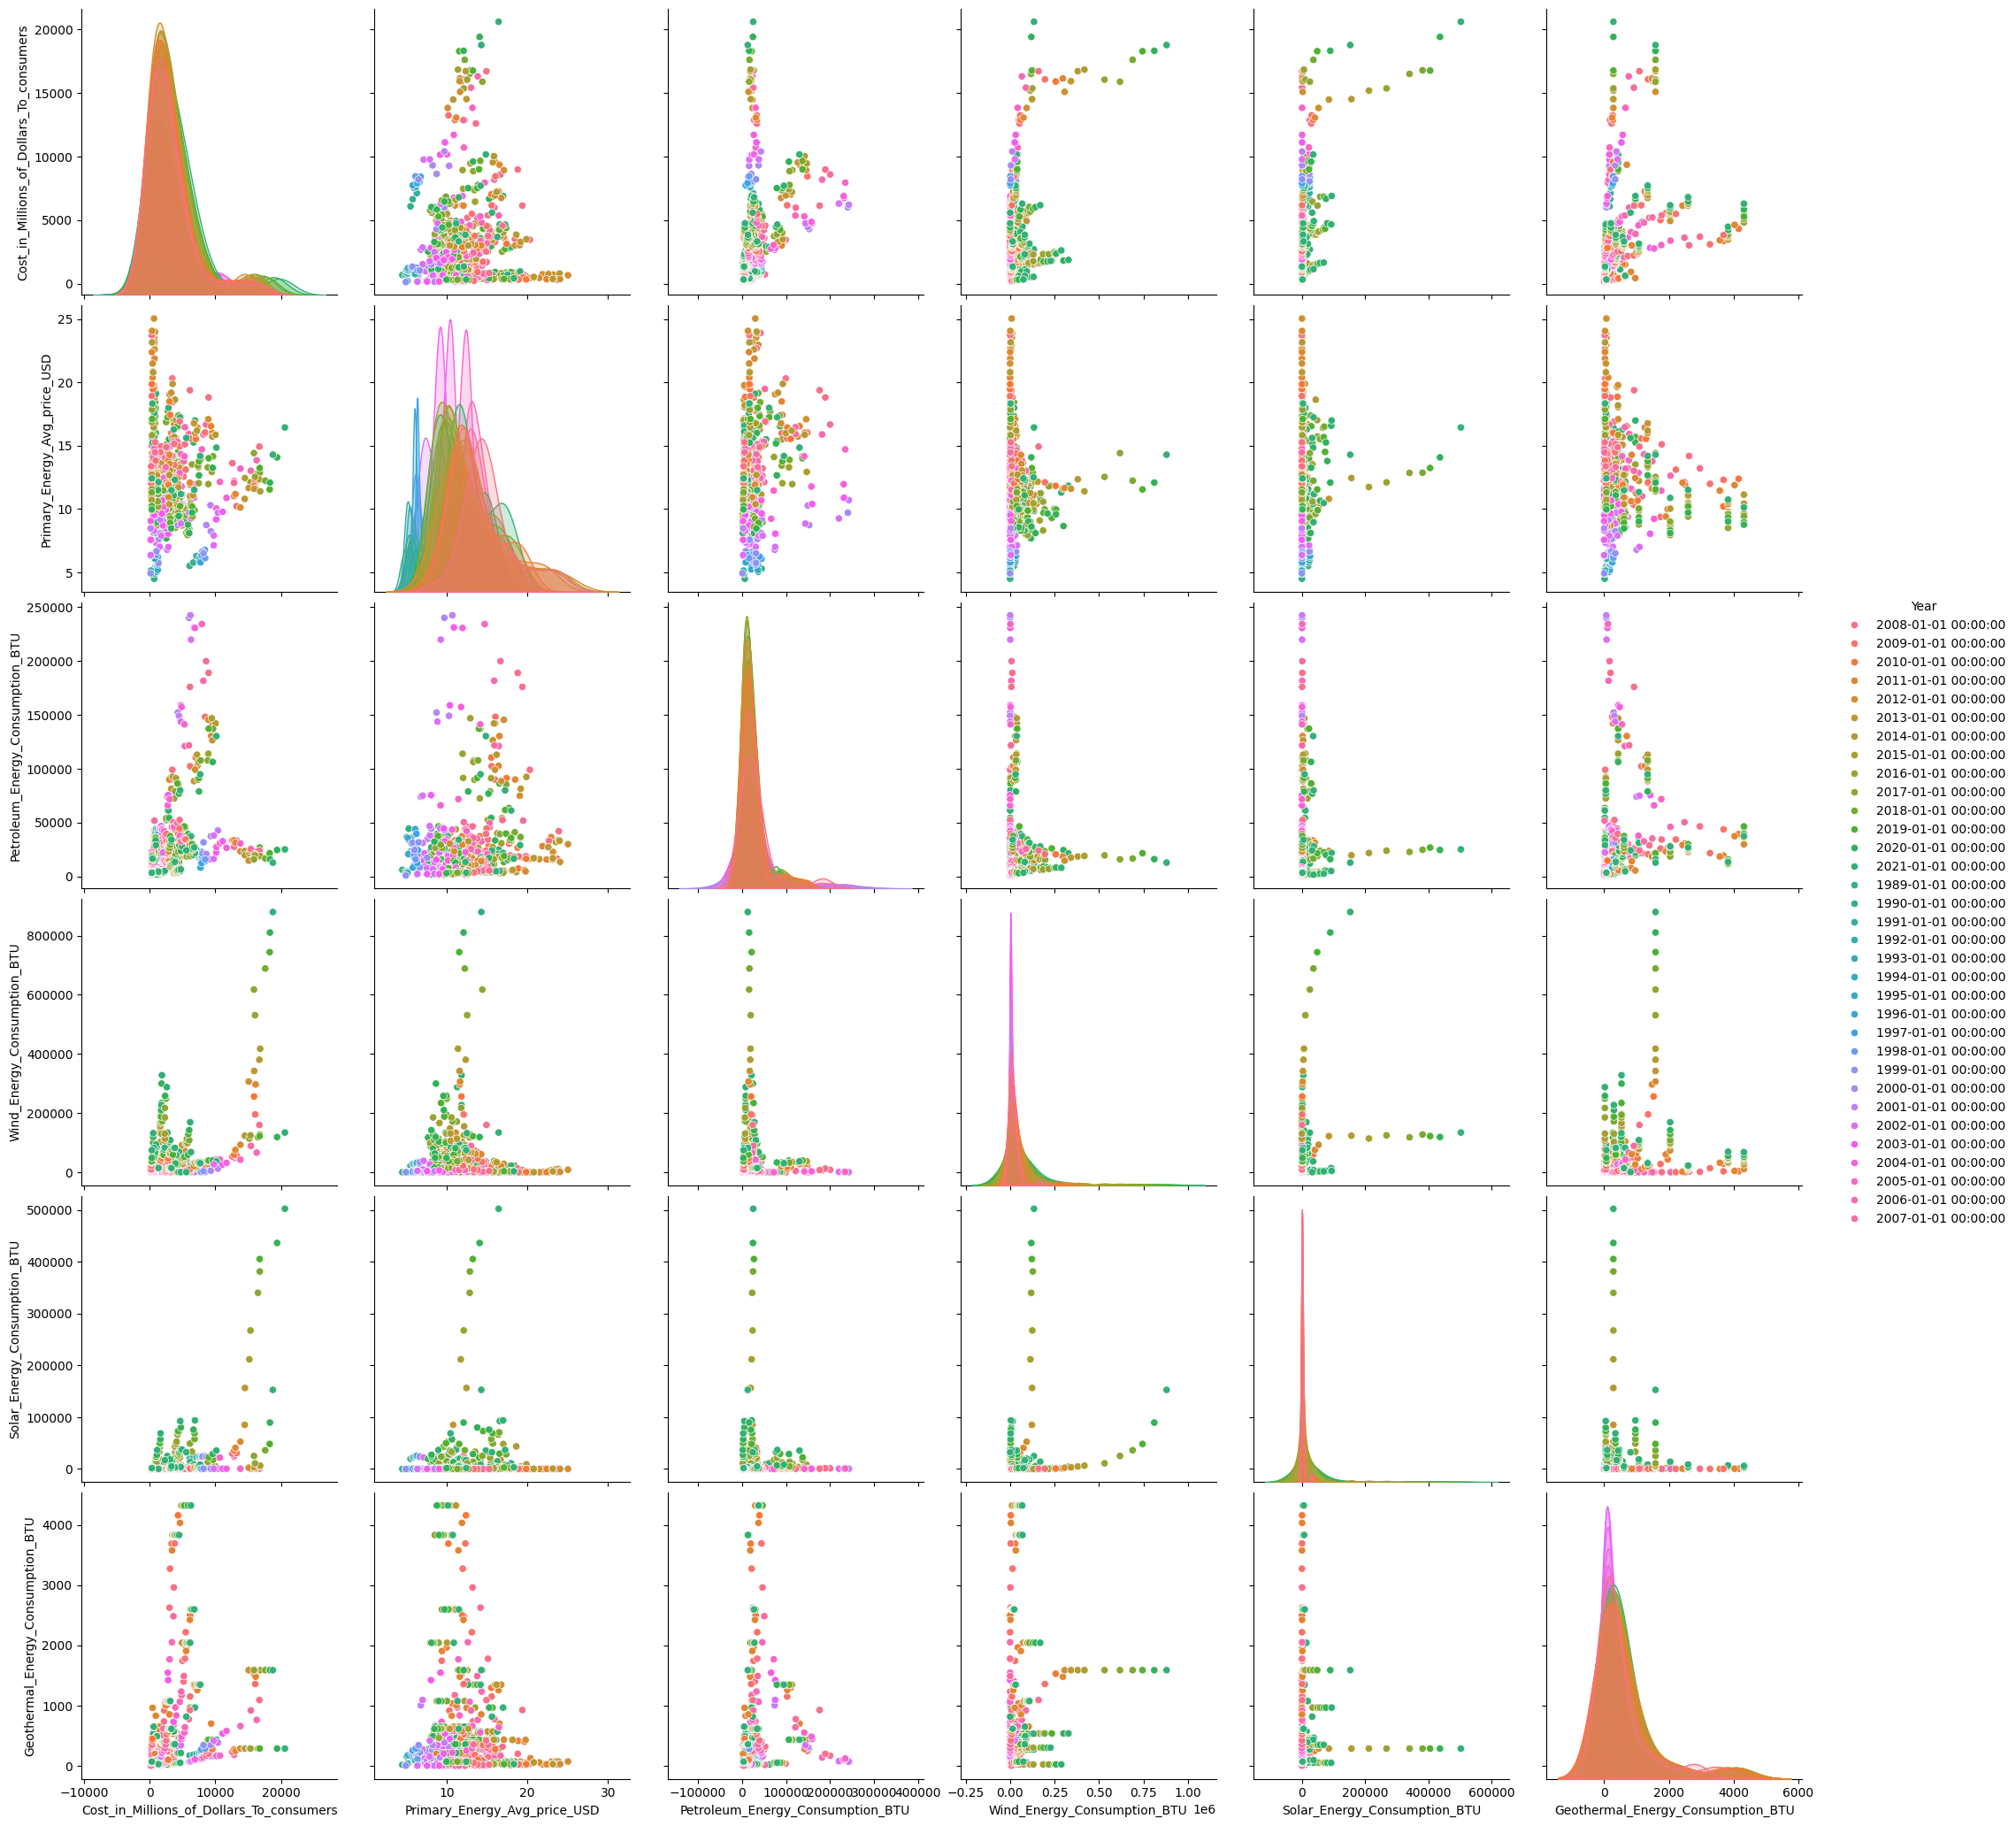

In [44]:
sns.pairplot(merged_data1,height=3.5,hue='Year')

In [45]:
grouped=merged_data1.groupby('StateCode')

looking at the histograms, the data appears to be 

In [46]:
import numpy as np
import statsmodels.api as sm
import pylab
import scipy.stats as stats

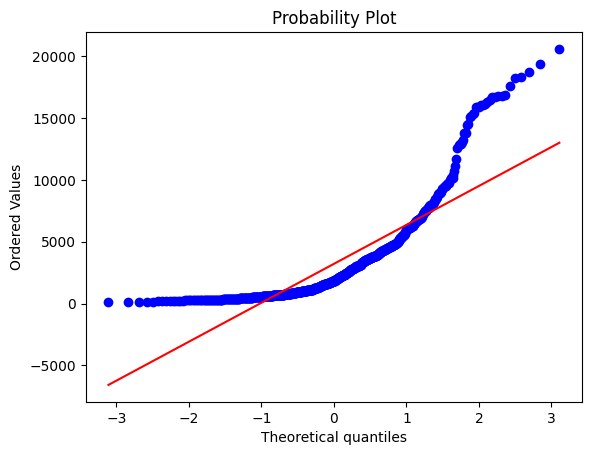

In [47]:
stats.probplot(merged_data1['Cost_in_Millions_of_Dollars_To_consumers'], plot=pylab)
pylab.show()

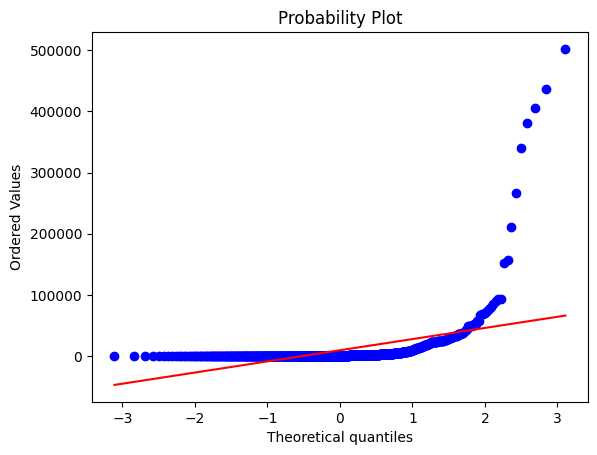

In [48]:
stats.probplot(merged_data1['Solar_Energy_Consumption_BTU'], plot=pylab)
pylab.show()

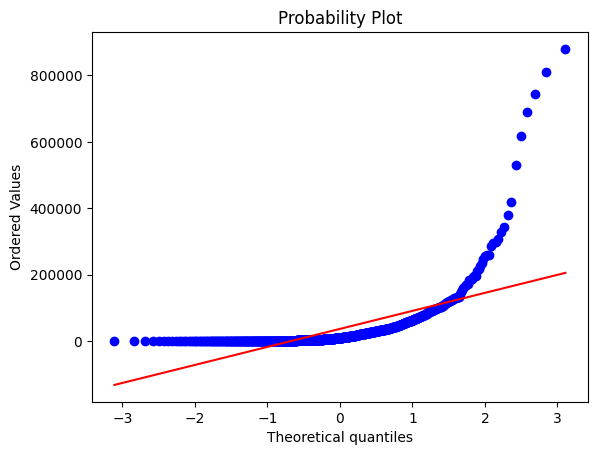

In [49]:
stats.probplot(merged_data1['Wind_Energy_Consumption_BTU'], plot=pylab)
pylab.show()

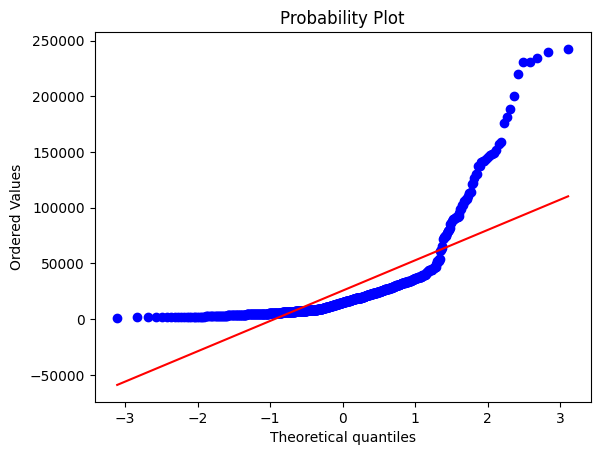

In [50]:
stats.probplot(merged_data1['Petroleum_Energy_Consumption_BTU'], plot=pylab)
pylab.show()

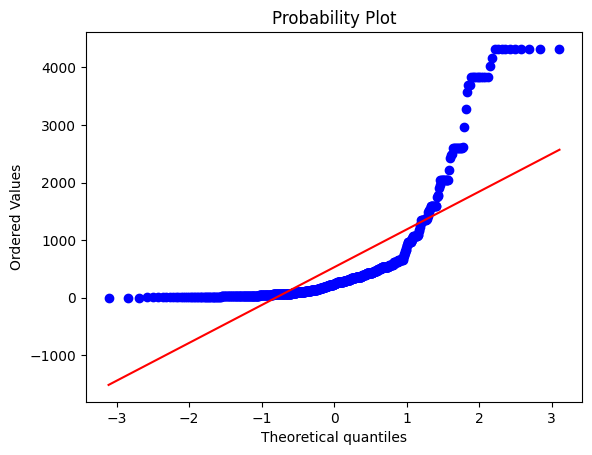

In [51]:
stats.probplot(merged_data1['Geothermal_Energy_Consumption_BTU'], plot=pylab)
pylab.show()

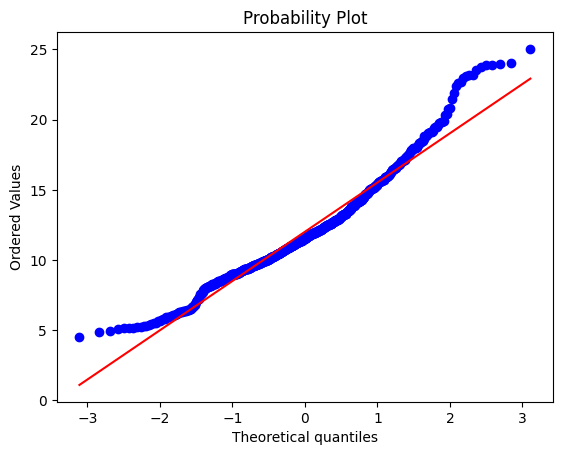

In [52]:
stats.probplot(merged_data1['Primary_Energy_Avg_price_USD'], plot=pylab)
pylab.show()

In [53]:
r = np.corrcoef(merged_data1['Solar_Energy_Consumption_BTU'], merged_data1['Cost_in_Millions_of_Dollars_To_consumers'])



In [54]:
import scipy.stats
scipy.stats.pearsonr(merged_data1['Solar_Energy_Consumption_BTU'], merged_data1['Cost_in_Millions_of_Dollars_To_consumers'])

PearsonRResult(statistic=0.5004167183314128, pvalue=3.7600747966825656e-48)

In [55]:
import scipy.stats
scipy.stats.pearsonr(merged_data1['Wind_Energy_Consumption_BTU'], merged_data1['Cost_in_Millions_of_Dollars_To_consumers'])

PearsonRResult(statistic=0.48565318067404495, pvalue=4.683573299826991e-45)

In [56]:
import scipy.stats
scipy.stats.pearsonr(merged_data1['Geothermal_Energy_Consumption_BTU'], merged_data1['Cost_in_Millions_of_Dollars_To_consumers'])

PearsonRResult(statistic=0.3114229201678072, pvalue=4.175312166492456e-18)

In [57]:
import scipy.stats
scipy.stats.pearsonr(merged_data1['Petroleum_Energy_Consumption_BTU'], merged_data1['Cost_in_Millions_of_Dollars_To_consumers'])

PearsonRResult(statistic=0.34541891985311796, pvalue=3.6654789006314e-22)

In [58]:
import scipy.stats
scipy.stats.pearsonr(merged_data1['Primary_Energy_Avg_price_USD'], merged_data1['Cost_in_Millions_of_Dollars_To_consumers'])

PearsonRResult(statistic=-0.0018236712892031885, pvalue=0.9605005964530186)

# First Model (Linear)
Going to just attempt this model

In [59]:
# shift column 'Name' to first position 
first_column = merged_data1.pop('Cost_in_Millions_of_Dollars_To_consumers') 
  
# insert column using insert(position,column_name, 
# first_column) function 
merged_data1.insert(0, 'Cost_in_Millions_of_Dollars_To_consumers', first_column) 

In [60]:
merged_data1.head(1)

,Cost_in_Millions_of_Dollars_To_consumers,Data_Status,Consumer_Energy_Cost_Abbr,StateCode,Year,Primary_Energy_Avg_price_abbr,Primary_Energy_Avg_price_USD,Petroleum_Energy_Total_abbr,Petroleum_Energy_Consumption_BTU,Wind_Energy_Total_abbr,Wind_Energy_Consumption_BTU,Solar_Energy_Total_abbr,Solar_Energy_Consumption_BTU,Geothermal_Energy_Total_abbr,Geothermal_Energy_Consumption_BTU
0,352.60,2021F,ESRCV,AK,2008-01-01,PERCD,13.78,PARCB,8749.00,WYTCB,1.00,SOTCB,2.00,GERCB,59.00


In [61]:
merged_data1_dropped= merged_data1.drop(['Data_Status','Consumer_Energy_Cost_Abbr','Wind_Energy_Total_abbr',
                                         'Solar_Energy_Total_abbr','Geothermal_Energy_Total_abbr','Petroleum_Energy_Total_abbr','Primary_Energy_Avg_price_abbr',],axis=1)

In [62]:
merged_data1_dropped.head()

,Cost_in_Millions_of_Dollars_To_consumers,StateCode,Year,Primary_Energy_Avg_price_USD,Petroleum_Energy_Consumption_BTU,Wind_Energy_Consumption_BTU,Solar_Energy_Consumption_BTU,Geothermal_Energy_Consumption_BTU
0,352.60,AK,2008-01-01,13.78,8749.00,1.00,2.00,59.00
1,362.90,AK,2009-01-01,13.00,9446.00,69.00,3.00,77.00
2,340.30,AK,2010-01-01,13.30,9359.00,123.00,3.00,79.00
3,376.00,AK,2011-01-01,14.19,8682.00,121.00,3.00,126.00
4,386.30,AK,2012-01-01,13.96,8362.00,356.00,3.00,101.00


In [63]:
selected_column = merged_data1_dropped
selected_column

,Cost_in_Millions_of_Dollars_To_consumers,StateCode,Year,Primary_Energy_Avg_price_USD,Petroleum_Energy_Consumption_BTU,Wind_Energy_Consumption_BTU,Solar_Energy_Consumption_BTU,Geothermal_Energy_Consumption_BTU
0,352.60,AK,2008-01-01,13.78,8749.00,1.00,2.00,59.00
1,362.90,AK,2009-01-01,13.00,9446.00,69.00,3.00,77.00
2,340.30,AK,2010-01-01,13.30,9359.00,123.00,3.00,79.00
3,376.00,AK,2011-01-01,14.19,8682.00,121.00,3.00,126.00
4,386.30,AK,2012-01-01,13.96,8362.00,356.00,3.00,101.00
...,...,...,...,...,...,...,...,...
735,315.30,WY,2017-01-01,11.57,3623.00,39785.00,45.00,70.00
736,310.20,WY,2018-01-01,11.32,3390.00,36912.00,67.00,70.00
737,318.40,WY,2019-01-01,10.24,3620.00,37045.00,1687.00,70.00
738,319.90,WY,2020-01-01,9.97,3066.00,48329.00,1565.00,70.00


In [64]:
#all_names = set(merged_data1_dropped['StateCode'])
#for name in all_names:
    #selected_column[name] = selected_column.apply(lambda row: 1 if name in row.values else 0, axis=1)

In [65]:
#selected_column
selected_column['Year1']=selected_column['Year']

In [66]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(selected_column['Year1'])
selected_column['Year1'] =le.transform(selected_column['Year1'])

In [67]:
le = LabelEncoder()
le.fit(selected_column['StateCode'])
selected_column['StateCode'] = le.transform(selected_column['StateCode'])

In [68]:
selected_column

,Cost_in_Millions_of_Dollars_To_consumers,StateCode,Year,Primary_Energy_Avg_price_USD,Petroleum_Energy_Consumption_BTU,Wind_Energy_Consumption_BTU,Solar_Energy_Consumption_BTU,Geothermal_Energy_Consumption_BTU,Year1
0,352.60,0,2008-01-01,13.78,8749.00,1.00,2.00,59.00,19
1,362.90,0,2009-01-01,13.00,9446.00,69.00,3.00,77.00,20
2,340.30,0,2010-01-01,13.30,9359.00,123.00,3.00,79.00,21
3,376.00,0,2011-01-01,14.19,8682.00,121.00,3.00,126.00,22
4,386.30,0,2012-01-01,13.96,8362.00,356.00,3.00,101.00,23
...,...,...,...,...,...,...,...,...,...
735,315.30,40,2017-01-01,11.57,3623.00,39785.00,45.00,70.00,28
736,310.20,40,2018-01-01,11.32,3390.00,36912.00,67.00,70.00,29
737,318.40,40,2019-01-01,10.24,3620.00,37045.00,1687.00,70.00,30
738,319.90,40,2020-01-01,9.97,3066.00,48329.00,1565.00,70.00,31


In [69]:
X1 =selected_column.loc[selected_column['Year']<'2021-01-01']
X2 = selected_column.loc[selected_column['Year']>='2021-01-01']

In [70]:
X1

,Cost_in_Millions_of_Dollars_To_consumers,StateCode,Year,Primary_Energy_Avg_price_USD,Petroleum_Energy_Consumption_BTU,Wind_Energy_Consumption_BTU,Solar_Energy_Consumption_BTU,Geothermal_Energy_Consumption_BTU,Year1
0,352.60,0,2008-01-01,13.78,8749.00,1.00,2.00,59.00,19
1,362.90,0,2009-01-01,13.00,9446.00,69.00,3.00,77.00,20
2,340.30,0,2010-01-01,13.30,9359.00,123.00,3.00,79.00,21
3,376.00,0,2011-01-01,14.19,8682.00,121.00,3.00,126.00,22
4,386.30,0,2012-01-01,13.96,8362.00,356.00,3.00,101.00,23
...,...,...,...,...,...,...,...,...,...
734,306.30,40,2016-01-01,9.91,2714.00,40505.00,33.00,70.00,27
735,315.30,40,2017-01-01,11.57,3623.00,39785.00,45.00,70.00,28
736,310.20,40,2018-01-01,11.32,3390.00,36912.00,67.00,70.00,29
737,318.40,40,2019-01-01,10.24,3620.00,37045.00,1687.00,70.00,30


In [71]:
y_train=X1['Cost_in_Millions_of_Dollars_To_consumers'].reset_index(drop=True) # Separating all of the data
y_test=X2['Cost_in_Millions_of_Dollars_To_consumers'].reset_index(drop=True)
X_train = X1.iloc[:,3: ]
X_test = X2.iloc[:,3: ]

In [72]:

X_train

,Primary_Energy_Avg_price_USD,Petroleum_Energy_Consumption_BTU,Wind_Energy_Consumption_BTU,Solar_Energy_Consumption_BTU,Geothermal_Energy_Consumption_BTU,Year1
0,13.78,8749.00,1.00,2.00,59.00,19
1,13.00,9446.00,69.00,3.00,77.00,20
2,13.30,9359.00,123.00,3.00,79.00,21
3,14.19,8682.00,121.00,3.00,126.00,22
4,13.96,8362.00,356.00,3.00,101.00,23
...,...,...,...,...,...,...
734,9.91,2714.00,40505.00,33.00,70.00,27
735,11.57,3623.00,39785.00,45.00,70.00,28
736,11.32,3390.00,36912.00,67.00,70.00,29
737,10.24,3620.00,37045.00,1687.00,70.00,30


In [73]:
X_test

,Primary_Energy_Avg_price_USD,Petroleum_Energy_Consumption_BTU,Wind_Energy_Consumption_BTU,Solar_Energy_Consumption_BTU,Geothermal_Energy_Consumption_BTU,Year1
13,13.62,8375.00,1169.00,112.00,101.00,32
26,16.58,5112.00,14153.00,92557.00,50.00,32
59,16.44,25138.00,134225.00,502419.00,287.00,32
80,9.84,11941.00,133772.00,24935.00,271.00,32
86,17.99,61268.00,113.00,10962.00,21.00,32
98,16.12,4854.00,43.00,1773.00,430.00,32
126,11.84,21401.00,328097.00,4209.00,538.00,32
142,9.89,5641.00,23704.00,6074.00,131.00,32
161,10.88,27944.00,169213.00,14000.00,2042.00,32
175,10.75,13480.00,69487.00,7149.00,3831.00,32


In [74]:
#X_train= X_train.drop(['Year'],axis=1)
#X_test= X_test.drop(['Year'],axis=1)

In [75]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [76]:
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 4.70098354e-01, -4.88940585e-01, -4.39379116e-01,
        -2.27843365e-01, -4.98301916e-01,  1.52390149e+00],
       [ 1.29450572e+00, -5.80594274e-01, -2.66449091e-01,
         2.45807750e+00, -5.59037573e-01,  1.52390149e+00],
       [ 1.25551348e+00, -1.80883705e-02,  1.33275408e+00,
         1.43663137e+01, -2.76795401e-01,  1.52390149e+00],
       [-5.82692134e-01, -3.88775997e-01,  1.32672071e+00,
         4.93370477e-01, -2.95849725e-01,  1.52390149e+00],
       [ 1.68721328e+00,  9.96759242e-01, -4.53443665e-01,
         8.73953323e-02, -5.93573535e-01,  1.52390149e+00],
       [ 1.16638836e+00, -5.87841179e-01, -4.54375974e-01,
        -1.79584243e-01, -1.06497383e-01,  1.52390149e+00],
       [-2.56601295e-02, -1.23056140e-01,  3.91487745e+00,
        -1.08808071e-01,  2.21193031e-02,  1.52390149e+00],
       [-5.68766334e-01, -5.65735309e-01, -1.39242169e-01,
        -5.46218801e-02, -4.62575058e-01,  1.52390149e+00],
       [-2.93035492e-01,  6.07287455e-02,  1.798

In [77]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
linear_model1=linear_model.LinearRegression()
linear_model=LinearRegression().fit(X_train,y_train)
y_pred = linear_model.predict(X_test)
y_true =y_test

In [78]:
y_pred

array([  248.66575442,  4585.79447615, 26311.07460629,  4319.12766321,
        2604.48758483,   613.77945694,  8185.13434904,   789.7736137 ,
        7015.79893217,  5963.6791662 ,  5197.44034695,  4436.43853378,
        1995.33886138,  1857.19974469,  7187.08199643,  5058.53604469,
        2039.59360325,   856.95256882,  5985.77185647,  3378.15995853,
        2269.23460068,  1232.75816967,  2864.07189568,  2841.43327206,
        3287.38992368,  7157.50767213,  4250.57049857,  6183.28028884,
        2883.87840554,  5535.78913018,   856.15708034,  2362.64455962,
         358.55659185, 27367.01744906,  1597.87876523,  3030.8008455 ,
         807.41500181,  2500.41826838,  2086.94217839,   268.15578469,
        1632.44092653])

In [79]:
np.array(y_true)

array([  469.9,  4655.9, 20604.4,  2696.1,  2868.4,   647.1,  1864.6,
         944.6,  6167.8,  4476.5,  1787.5,  4647.9,  3669.2,   861.6,
        6289.8,  3138.3,  4071.5,   623.9,  6897. ,   530.3,  1128. ,
         959.2,  4921.1,   958.1,  1651.8, 10161.8,  6789.2,  2612.4,
        2307.4,  7697.6,   698.4,   616.5,  4741.6, 18772.3,  1142.2,
        5579.6,   418.7,  3843.7,  3320.2,  1343.2,   323.7])

In [80]:
results_trial1=pd.DataFrame(y_pred,y_true).reset_index()
results_trial1=results_trial1.rename(columns={'Cost_in_Millions_of_Dollars_To_consumers':'true',0:'predicted'})
results_trial1['how_off']= ((results_trial1['true']-results_trial1['predicted'])/results_trial1['true'])*100
results_trial1

,true,predicted,how_off
0,469.90,248.67,47.08
1,4655.90,4585.79,1.51
2,20604.40,26311.07,-27.70
3,2696.10,4319.13,-60.20
4,2868.40,2604.49,9.20
5,647.10,613.78,5.15
6,1864.60,8185.13,-338.98
7,944.60,789.77,16.39
8,6167.80,7015.80,-13.75
9,4476.50,5963.68,-33.22


In [81]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score
y = y_true
pred = y_pred
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)

ValueError: continuous format is not supported